In [1]:
%load_ext autoreload

In [2]:
from renewableopt.battery.data_import import DATA_DIR
from renewableopt.battery.feature_extraction import CapacityData

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
c = CapacityData.load(DATA_DIR / "aging.npz")

In [5]:
exp = pd.read_csv(DATA_DIR / "experiments_meta.csv")

In [13]:
exp.columns

Index(['serial_internal', 'serial', 'lab', 'type', 'tp', 'cell', 'amb_temp_tp',
       'soc_max_tp', 'dod_tp', 'c_ch_tp', 'c_dch_tp', 'sampling', 'stage',
       'm_0', 'scale', 'R_1khz_0', 'resistance_meter', 'U_0', ' volt_meter'],
      dtype='object')

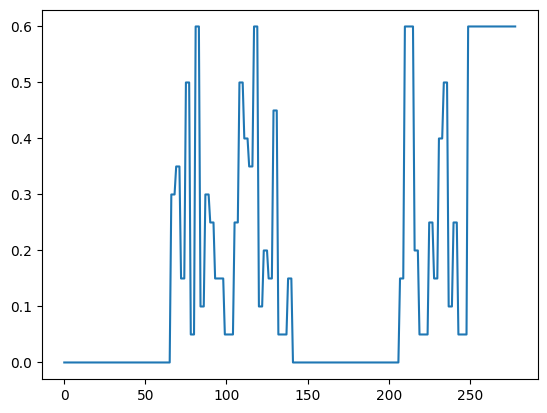

In [22]:
plt.plot(exp['dod_tp'])

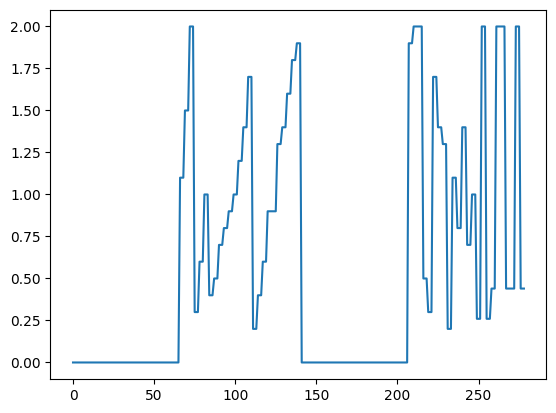

In [24]:
plt.plot(exp['c_dch_tp'])

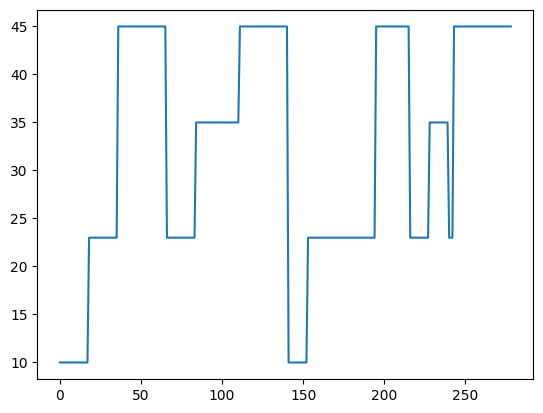

In [25]:
plt.plot(exp['amb_temp_tp'])

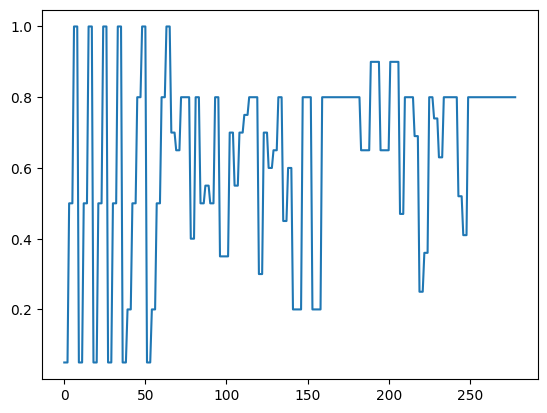

In [26]:
plt.plot(exp['soc_max_tp'])

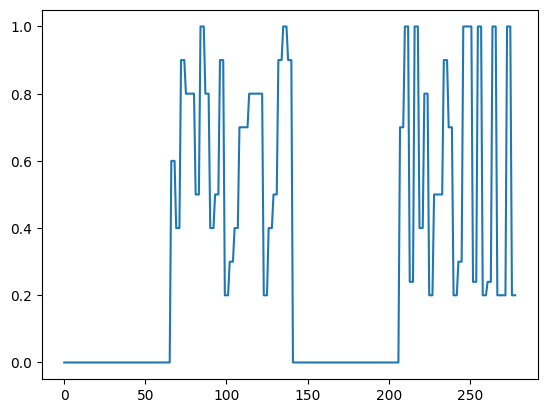

In [23]:
plt.plot(exp['c_ch_tp'])

In [14]:
exp.serial

0      TP_k01_01
1      TP_k01_02
2      TP_k01_03
3      TP_k02_01
4      TP_k02_02
         ...    
274    TP_z23_02
275    TP_z23_03
276    TP_z24_01
277    TP_z24_02
278    TP_z24_03
Name: serial, Length: 279, dtype: object

In [18]:
exp[' volt_meter']

0       Fluke 189
1       Fluke 189
2       Fluke 189
3       Fluke 189
4       Fluke 189
          ...    
274    HIOKI 3554
275    HIOKI 3554
276    HIOKI 3554
277    HIOKI 3554
278    HIOKI 3554
Name:  volt_meter, Length: 279, dtype: object

In [20]:
import sklearn

In [ ]:
sk

In [ ]:
plt.plot(

In [167]:
COLUMNS = [
    "T_a", "delta", "Q", "gamma_c", "gamma_d", "n_f"
]
for i, c in enumerate(COLUMNS):
    print(f"{c}: {np.unique(round_sigfig(X[:, i], 0))}")

T_a: [0.  0.4 0.7 1. ]
delta: [0.05 0.1  0.2  0.3  0.4  0.5  0.6 ]
Q: [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
gamma_c: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
gamma_d: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  2. ]
n_f: [0.    0.005 0.006 0.008 0.009 0.01  0.02  0.03  0.04  0.05  0.06  0.07
 0.08  0.09  0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.   ]


In [164]:
def _round_sigfig(x, n):
    
    if np.isnan(x) or x == 0:
        return x
    try:
        return round(x, -int(np.floor(np.sign(x) * np.log10(abs(x)))) + n)
    except ValueError:
        print(x)
    
def round_sigfig(x, n):
    return np.array([_round_sigfig(x_i, n) for x_i in x])

In [155]:
np.full(3, 0.00001234).astype(int)

array([0, 0, 0])

In [158]:
round_sigfig(np.full(3, 0.00001234), 0)

array([1.e-05, 1.e-05, 1.e-05])

In [140]:
help(np.round) # (0.00001, 1)

Help on function round_ in module numpy:

round_(a, decimals=0, out=None)
    Round an array to the given number of decimals.
    
    See Also
    --------
    around : equivalent function; see for details.



In [10]:
def row_from_uid(uid, exp):
    serial = uid[:9]
    stage = int(uid[-1])
    row = exp[
        (exp['serial'] == serial) &
        (exp['stage'] == stage)]
    if len(row) == 0:
        raise ValueError(f"UID {uid} not found")
    elif len(row) > 1:
        raise ValueError(f"Multiple UIDs found!")
    return row.iloc[0]

In [121]:
def prepare_cycling_capacity_fit(c: CapacityData, exp: pd.DataFrame):
    uids = sorted(list(c.keys()))
    # Filter out cell where the data was missing or corrupted.
    uids = [uid for uid in uids if c[uid] is not None]

    X = []  # Features to fit, tuples of (T_a, delta, Q, gamma+, gamma-, n_F)
    y = []  # Capacities
    
    for uid in uids:
        row = row_from_uid(uid, exp)
        T_a = row["amb_temp_tp"]
        delta = row["dod_tp"]
        Q = row["soc_max_tp"]
        gamma_ch = row["c_ch_tp"]
        gamma_dch = row["c_dch_tp"]
        checkups = list(c[uid].iter())
        N = len(checkups)
        for i, (cap, n_f) in enumerate(checkups):
            if i == 0 or i == N - 3:
                T = 10
            elif i == 1 or i == N - 2:
                T = 23
            elif i == 2 or i == N - 1:
                T = 45
            else:
                T = T_a
                
            x_i = [T, delta, Q, gamma_ch, gamma_dch, n_f]
            if np.any(np.isnan(x_i)) or np.isnan(cap):
                continue
            X.append(x_i)
            y.append(cap)

    # Normalize n_F
    X = np.array(X)
    return np.array(X), np.array(y)
    
    

In [122]:
def scale(x):
    m = min(x)
    M = max(x)
    scaled = (x - m) / (M - m)
    def unscale(z):
        return m + z * (M - m)
    return scaled, unscale
    

In [123]:
X

array([], dtype=float64)

In [124]:
X, y = prepare_cycling_capacity_fit(c, exp)
max_cycles = max(X[:, 5])
X[:, 5], unscale_cycles = scale(X[:, 5])
X[:, 0], unscale_temp = scale(X[:, 0])

In [180]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Step 2: Define the kernel and GP model
# Kernel: ConstantKernel (signal variance) * RBF (length scale)
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
kernel = RBF(10, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel,
                              optimizer=None,
                              # n_restarts_optimizer=10,
                              normalize_y=True,
                              alpha=1.0)

# Step 3: Train the model
gp.fit(X, y)


GaussianProcessRegressor(alpha=1.0, kernel=RBF(length_scale=10),
                         normalize_y=True, optimizer=None)

In [181]:
max(X[:, 0])

1.0

In [182]:
unscale_temp(0)

10.0

In [183]:
# (T_amb, DoD, SoC_max, charge_current, discharge_current, n_fe]
# Iterate over n_fe:
n_evals = 1000
fixed = [0, 0.1, 0.5, 1.0, 1]

X_test = np.c_[np.full((n_evals, len(fixed)), fixed), np.linspace(0, 1, n_evals)]

In [184]:
unscale_temp(1)

45.0

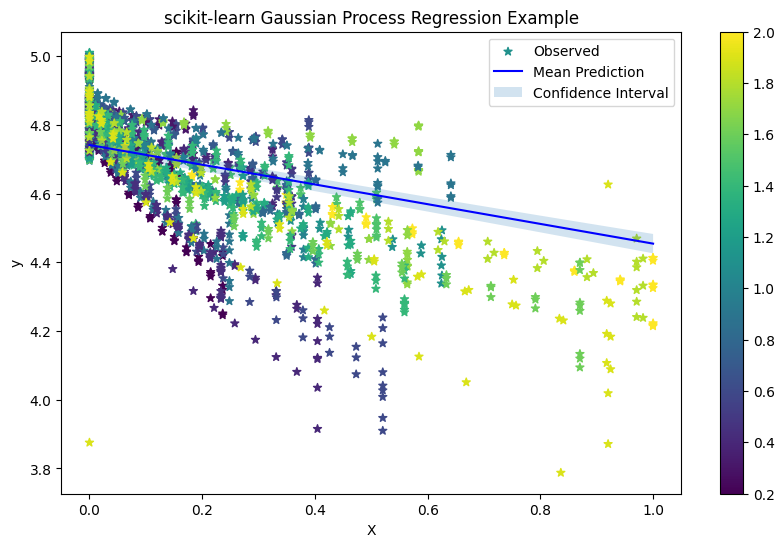

In [185]:

# Step 4: Make predictions
# X_test = np.linspace(0, 5, 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_test, return_std=True)

# Step 5: Plot the results
plt.figure(figsize=(10, 6))
filt = unscale_temp(X[:, 0]) > 40
plt.scatter(X[:, 5], y, c=X[:, 4], marker="*", label="Observed")
# plt.plot(X[filt, 5], y[filt], 'k*', label='Observed Data (T>40)')
# plt.plot(X[~filt, 5], y[~filt], 'r*', label='Observed Data (T<40)')
plt.plot(X_test[:, 5], y_pred, 'b', label='Mean Prediction')
plt.fill_between(X_test[:, 5],
                 y_pred - 1.96 * sigma,
                 y_pred + 1.96 * sigma,
                 alpha=0.2,
                 label='Confidence Interval')
plt.colorbar()
plt.legend()
plt.title('scikit-learn Gaussian Process Regression Example')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

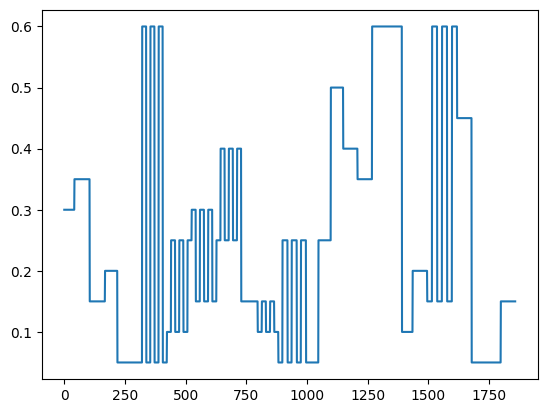

In [113]:
plt.plot(X[:, 1])

In [107]:
X[0, :]

array([0. , 0.3, 0.7, 0.6, 1.1, 0. ])

In [111]:
X[2, :]

array([0. , 0.3, 0.7, 0.6, 1.1, 0. ])

In [32]:
help(plt.fill_between)

Help on function fill_between in module matplotlib.pyplot:

fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)
    Fill the area between two horizontal curves.
    
    The curves are defined by the points (*x*, *y1*) and (*x*,
    *y2*).  This creates one or multiple polygons describing the filled
    area.
    
    You may exclude some horizontal sections from filling using *where*.
    
    By default, the edges connect the given points directly.  Use *step*
    if the filling should be a step function, i.e. constant in between
    *x*.
    
    Parameters
    ----------
    x : array (length N)
        The x coordinates of the nodes defining the curves.
    
    y1 : array (length N) or scalar
        The y coordinates of the nodes defining the first curve.
    
    y2 : array (length N) or scalar, default: 0
        The y coordinates of the nodes defining the second curve.
    
    where : array of bool (length N), optional
        Define *